<a href="https://colab.research.google.com/github/d-vf/Var_Volt_Control/blob/main/implementation/Clean_Var_Volt_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Libraries

In [34]:
! apt-get install -y graphviz libgraphviz-dev #data viz
! pip install pygraphviz diagrams # diagrams
! pip install pandapower["all"] #data
! pip install scipy #transform .m to .pp
! pip install pydot graphviz # for HG
! pip install plotly #cute plots
! pip install -U kaleido #to save png IO

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-package

# Data

In [35]:
import os
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Data")

In [36]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Data")
if not os.path.exists("images"):
    os.mkdir("images")

# Simulation

*  using same of prior work

In [37]:
import pandas as pd
cluster_medians_solar = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_com.csv', header=0, sep=',')

Bus voltage results:
       vm_pu  va_degree
0   1.000000   0.000000
1   1.000000   0.000000
2   0.983302 -30.386276
3   0.975552 -30.156447
4   0.967817 -29.922940
5   0.960099 -29.685675
6   0.955688 -29.502395
7   0.951286 -29.317416
8   0.946894 -29.130719
9   0.942512 -28.942284
10  0.938141 -28.752092
11  0.938141 -28.752092
12  0.967817 -29.922940
13  0.947791 -29.114552
14  0.935579 -28.528460
15  0.923468 -27.926930
16  0.913170 -27.398683
17  0.951286 -29.317416
18  0.926906 -27.669929
19  0.938141 -28.752092
20  1.000000   0.000000
21  0.980567 -30.670595
22  0.955384 -29.881137
23  1.000000   0.000000
24  0.967055 -31.267080
25  0.937078 -30.880952
26  0.907147 -30.469323
27  0.887022 -30.175064
28  0.866922 -29.867151
29  0.856829 -29.705144
30  0.846744 -29.539278
31  0.836666 -29.369413
32  0.836666 -29.369413
33  0.886274 -29.719544
34  0.865560 -28.933739
35  0.865560 -28.933739
36  0.836223 -27.526938
37  0.886274 -29.719544
38  0.845664 -29.045157
39  0.845664 -29.04

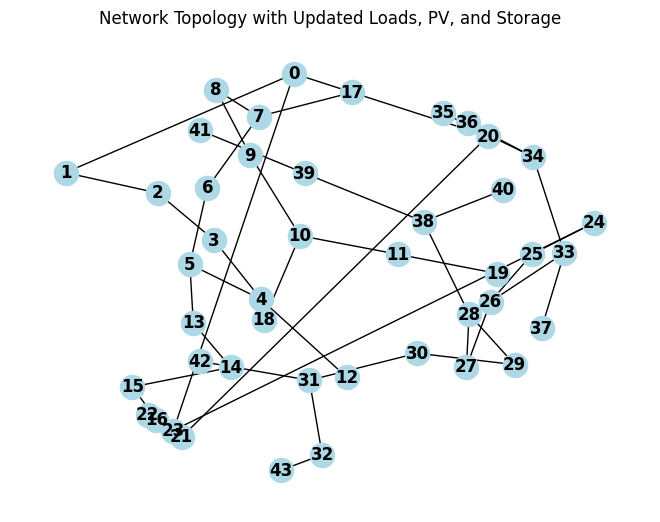

In [38]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio
import networkx as nx
import numpy as np
import pandas as pd
import math
from pandapower.control import ConstControl
from pandapower.pypower.makeYbus import makeYbus
import matplotlib.pyplot as plt


# Create and visualize the network
net = pn.create_cigre_network_lv()
net.name = "cigre network lv"
fig = vlevel_plotly(net)
pio.show(fig)
n_buses = len(net.bus)

# Prepare the network for simulation: Remove existing loads, sgens, and gens
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Process load data from cluster medians (select hour 11)
transposed_df = cluster_medians.T
first_row = transposed_df.iloc[:, 11]

# Identify extreme buses based on the network graph
graph = pp.topology.create_nxgraph(net)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# For simplicity, split the extreme buses into two groups
selected_buses_odd = extreme_buses[1::2]    # for loads
selected_buses_even = extreme_buses[0::2]   # for solar/PV & storage

# Define a scaling factor to simulate large deviations
large_load_factor = 5.0  # Increase load by 5 times
## voltage drop

# Add loads to selected odd buses using load data
for bus in selected_buses_odd:
    # Use the first value of the load profile (in Watts)
    load = first_row.iloc[0] * large_load_factor
    q_value = np.abs(load * np.tan(np.arccos(0.7)))  # assume PF = 0.7
    sn_mva = np.sqrt((load/1e3)**2 + (q_value/1e3)**2)
    pp.create_load(net, bus=bus, p_mw=load/1e3, q_mvar=q_value/1e3,
                   scaling=1.0, sn_mva=sn_mva, in_service=True, controllable=True)

# Process solar data from cluster medians for solar generation (select hour 11)
transposed_df_solar = cluster_medians_solar.T
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add PV (solar generation) to selected even buses – mark all as controllable
for bus in selected_buses_even:
    solar_value = first_row_solar.iloc[0]  # use first solar value (Watts)
    q_solar = np.abs(solar_value * np.tan(np.arccos(0.7)))
    sn_mva = np.sqrt((solar_value/1e3)**2 + (q_solar/1e3)**2)
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_solar/1e3,
                   sn_mva=sn_mva, scaling=5.0, type='wye', in_service=False, controllable=True)

#in_service=False will prevent those elements from being included in the power flow calculation.

# Increase reactive power demand at bus 18
if not net.load[net.load.bus == 18].empty:
    idx = net.load[net.load.bus == 18].index[0]
    # Increase reactive demand (e.g., double it)
    net.load.at[idx, 'q_mvar'] = net.load.at[idx, 'q_mvar'] * 2.0
else:
    print("No load found at bus 18.")

# Add additional controllable sgens for voltage control and storage
# (All PV and storage assets are controllable.)

#for bus in selected_buses_even:
    # Additional PV asset for voltage control
#    pp.create_sgen(net, bus=bus, p_mw=0.005, q_mvar=0.0, scaling=1.0,
#                   controllable=True, in_service=True, max_q_mvar=0.005, min_q_mvar=-0.005)
    # Storage asset (modeled as sgen) for voltage support
    #pp.create_sgen(net, bus=12, p_mw=0.2, q_mvar=0.2, scaling=1.0,
#controllable=True, in_service=True, max_q_mvar=0.4, min_q_mvar=-0.04)

# additional controllable loads if desired
#for bus in selected_buses_even:
#    pp.create_load(net, bus=bus, p_mw=0.003, q_mvar=0.001, scaling=1.0,
#                   controllable=True, in_service=True)


# Create external grid connection if not already present (assume at bus 0)
if net.ext_grid.empty:
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

# Run power flow and check voltage results
pp.runpp(net)
print("Bus voltage results:")
print(net.res_bus[['vm_pu', 'va_degree']])

# Store baseline voltage deviations
baseline_voltages = net.res_bus['vm_pu'].copy()

# Create a reactive power controller for controllable sgens
ConstControl(net, element='sgen', variable='q_mvar',
             element_index=net.sgen[net.sgen.controllable].index,
             profile_name='reactive_power_profile')

#  Visualize the network with updated elements
graph = pp.topology.create_nxgraph(net)
nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
plt.title("Network Topology with Updated Loads, PV, and Storage")
plt.show()

# Construct the Adjacency Matrix from network elements
adj_matrix = np.zeros((n_buses, n_buses))
delta_rad = math.radians(30)  # default angle for capacity calculation

# Lines: Use reactance and bus voltages to approximate capacity
for i, line in net.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km  # if length available, multiply by line length

    v_from = net.res_bus.vm_pu.loc[from_bus] * net.bus.vn_kv.loc[from_bus]
    v_to = net.res_bus.vm_pu.loc[to_bus] * net.bus.vn_kv.loc[to_bus]
    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)
    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Transformers: Use rated capacity (sn_mva)
for i, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva
    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva

# External grid connections: Connect external grid bus to others (approximation)
for i, eg in net.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net.bus.vn_kv.loc[bus]
    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Switches: If open, set connection capacity to zero
for i, switch in net.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)
    if switch.closed:
        if switch.et in ['l', 't']:  # Line or transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch; use custom logic (here zero)
            P_capacity_switch = 0
    else:
        P_capacity_switch = 0
    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

# Additional connection: Link external grid with transformer HV buses
ext_grid_bus = net.ext_grid.bus.values[0]
s_sc_max_mva = net.ext_grid.s_sc_max_mva.values[0] if 's_sc_max_mva' in net.ext_grid.columns else 0
for i, hv_bus in enumerate(net.trafo.hv_bus.values):
    trafo_capacity = net.trafo.sn_mva.values[i]
    connection_capacity = min(s_sc_max_mva, trafo_capacity) if s_sc_max_mva else trafo_capacity
    adj_matrix[ext_grid_bus, hv_bus] = connection_capacity
    adj_matrix[hv_bus, ext_grid_bus] = connection_capacity

adj_matrix_df = pd.DataFrame(adj_matrix)
#print("Adjacency Matrix:")
#print(adj_matrix_df)

In [39]:
Ybus, Yf, Yt = makeYbus(net._ppc['baseMVA'], net._ppc['bus'], net._ppc['branch'])
Ybus_dense = Ybus.todense()
print("Ybus shape:", Ybus_dense.shape)

Ybus shape: (44, 44)


In [40]:
J = net._ppc["internal"]["J"].todense()
J.shape

(80, 80)

In [43]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
from pandapower.pypower.makeYbus import makeYbus


# Define the Full Jacobian (Sensitivity) Function

def create_full_jacobian(Ybus_full, bus_df):
    """
    Compute the full Jacobian submatrices (H, N, K, L) for all buses
    using the full Ybus matrix and bus voltage data.

    Parameters
    ----------
    Ybus_full : np.ndarray
        The full bus admittance matrix in dense format (n_buses x n_buses).
    bus_df : pandas.DataFrame
        DataFrame containing bus voltage magnitudes 'vm_pu' (in p.u.) and
        voltage angles 'va_degree' (in degrees).

    Returns
    -------
    H, N, K, L : np.ndarray
        The Jacobian submatrices:
          H: ∂P/∂θ sensitivities,
          N: ∂P/∂V sensitivities,
          K: ∂Q/∂θ sensitivities,
          L: ∂Q/∂V sensitivities.
    """
    nbus = len(bus_df)
    # Extract voltage magnitudes and convert angles to radians.
    V = bus_df["vm_pu"].values
    theta = np.deg2rad(bus_df["va_degree"].values)

    # Initialize submatrix arrays.
    H = np.zeros((nbus, nbus))
    N = np.zeros((nbus, nbus))
    K = np.zeros((nbus, nbus))
    L = np.zeros((nbus, nbus))

    # Extract conductance (G) and susceptance (B) matrices.
    G = np.array(Ybus_full.real)
    B = np.array(Ybus_full.imag)

    # --- Off-diagonal entries (i != j) ---
    for i in range(nbus):
        for j in range(nbus):
            if i != j:
                dtheta = theta[i] - theta[j]
                H[i, j] = V[i] * V[j] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta))
                N[i, j] = V[i] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta))
                K[i, j] = -V[i] * V[j] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta))
                L[i, j] = V[i] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta))

    # --- Diagonal entries ---
    for i in range(nbus):
        H[i, i] = -np.sum([H[i, j] for j in range(nbus) if j != i])
        N[i, i] = 2 * V[i] * G[i, i] + np.sum([N[i, j] for j in range(nbus) if j != i])
        K[i, i] = -np.sum([K[i, j] for j in range(nbus) if j != i])
        L[i, i] = -2 * V[i] * B[i, i] + np.sum([L[i, j] for j in range(nbus) if j != i])

    return H, N, K, L


# 4. Compute the Sensitivity (Jacobian) Matrices Using Ybus

H, N, K, L = create_full_jacobian(Ybus_dense, net.res_bus)

# Display the shapes of the resulting Jacobian submatrices.
print("Jacobian Submatrices shapes:")
print("H", H.shape)
print("N:", N.shape)
print("K:", K.shape)
print("L:", L.shape)
H

Jacobian Submatrices shapes:
H_full: (44, 44)
N_full: (44, 44)
K_full: (44, 44)
L_full: (44, 44)


array([[ 18.96272796,  -8.71794533,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-11.65912126,  32.49249502, -20.83337376, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.        ,   1.37874007,   9.53585358, ...,  -0.        ,
         -0.        ,  -0.        ],
       ...,
       [ -0.        ,  -0.        ,   0.        , ...,  -0.        ,
         -0.        ,   0.        ],
       [ -0.        ,  -0.        ,   0.        , ...,   0.        ,
         -0.        ,   0.        ],
       [ -0.        ,  -0.        ,   0.        , ...,  -0.        ,
         -0.        ,  -0.        ]])

In [42]:
#Ybus = Ybus.toarray()

G_mat = Ybus_dense.real
B_mat = Ybus_dense.imag

# Simple approximations for sensitivity matrices:
H = -B_mat   # Sensitivity of ΔP to Δθ
N = G_mat    # Sensitivity of ΔP to ΔV
K = -G_mat   # Sensitivity of ΔQ to Δθ
L = -B_mat   # Sensitivity of ΔQ to ΔV

##https://github.com/e2nIEE/pandapower/blob/develop/pandapower/pf/create_jacobian.py

# Simulation setup

In [10]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import networkx as nx

# Total number of buses
num_buses = len(net.bus)

# Voltage Limits
V0_kv = net.bus.vn_kv.values
V0 = V0_kv * 1e3  # in Volts
V_min = 0.95 * V0  # Minimum voltage for each bus
V_max = 1.05 * V0  # Maximum voltage for each bus

# Cost Weights

alpha = np.ones(num_buses)  # Weight on (ΔV)^2
beta = 0.1                  # Activation cost weight

# Initialize Primal and Dual Variables
# Initialize additional arrays and dual variables
lambda_P   = np.zeros(num_buses)   # Dual variable for active power
lambda_Q   = np.zeros(num_buses)   # Dual variable for reactive power
Delta_V    = 0.01 * np.random.randn(num_buses)   # Voltage deviation (V)
Delta_theta = 0.01 * np.random.randn(num_buses)   # Angle deviation (rad)
z = 0.5 + 0.05 * np.random.randn(num_buses)
z = np.clip(z, 0, 1)

# Extract Data from the Pandapower Network
# Baseline injections from the power flow results (in MW and MVAr)
P0 = net.res_bus.p_mw.values  # Active power injection at each bus (MW)
Q0 = net.res_bus.q_mvar.values  # Reactive power injection (MVAr)

P = np.copy(P0)
Q = np.copy(Q0)

# Use Actual Load Values from net.load
P_load = np.zeros(num_buses)
Q_load = np.zeros(num_buses)
for _, row in net.load.iterrows():
    bus_idx = int(row.bus)
    P_load[bus_idx] += row.p_mw
    Q_load[bus_idx] += row.q_mvar

# Initialize Control Variables for Controllable Buses
P_ctrl = np.zeros(num_buses)  # Active power control variable (MW)
Q_ctrl = np.zeros(num_buses)  # Reactive power control variable (MVAr)
S_max   = np.zeros(num_buses)  # Maximum apparent power (MVA)

# Extract Controllable Buses from sgen Table
# Only sgens (static generators) are controllable
controllable_buses = net.sgen.bus.values.astype(int)

# For controllable buses, assign the sgen values as initial control values
for bus in controllable_buses:
    # If multiple sgens exist at a bus, use the first one
    sgen_entry = net.sgen[net.sgen.bus == bus].iloc[0]
    P_ctrl[bus] = sgen_entry.p_mw    # MW
    Q_ctrl[bus] = sgen_entry.q_mvar  # MVAr
    S_max[bus]   = sgen_entry.sn_mva   # Maximum apparent power (MVA)
    z[bus]       = 1.0               # Set as active

# Optimization Parameters

iterations = 100
mu = 0.01
rho_dual = 0.01
epsilon = 0.01       # consensus step size
epsilon_innov = 0.01 # innovation step size
gamma = 0.01         # correction for updating z via consensus

In [44]:
# ---------- Baseline Power Flow Results (Before Voltage Control) ----------

# Run power flow to get traditional measures (baseline, before voltage control is applied)
pp.runpp(net)

# Total resistive losses computed from line results (active power losses in MW)
total_losses = net.res_line.pl_mw.sum()

# Traditional voltage profile from power flow results (in kV)
trad_voltage = net.res_bus.vm_pu.values * V0_kv

In [45]:
total_losses

np.float64(0.060383106490760396)

In [46]:
from pandapower.plotting.plotly import pf_res_plotly
#https://pandapower.readthedocs.io/en/latest/plotting/plotly/built-in_plots.html

pf_res_plotly(net)


Power Flow Results (Bus Voltages and Angles):


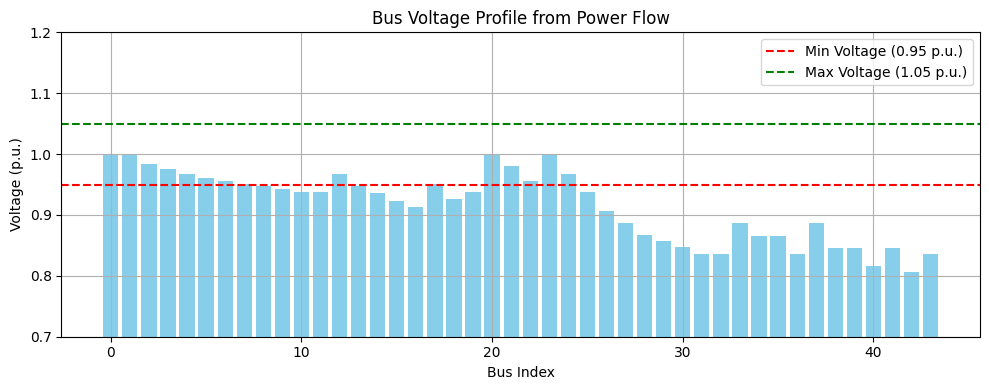

In [47]:
print("\nPower Flow Results (Bus Voltages and Angles):")
#print(net.res_bus[['vm_pu', 'va_degree']])

bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

# Save the initial bus results for later comparison
before_df = net.res_bus[['vm_pu', 'va_degree']].copy()

plt.figure(figsize=(10, 4))
plt.bar(bus_indices, voltages, color='skyblue')
plt.axhline(0.95, color='red', linestyle='--', label='Min Voltage (0.95 p.u.)')
plt.axhline(1.05, color='green', linestyle='--', label='Max Voltage (1.05 p.u.)')
plt.xlabel("Bus Index")
plt.ylabel("Voltage (p.u.)")
plt.title("Bus Voltage Profile from Power Flow")
plt.ylim(0.7, 1.2)  # Set y-axis limits between 0.7 and 1.2
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Assume net.res_bus is a pandas DataFrame containing the power flow results.
bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

# Save the initial bus results for later comparison
before_df = net.res_bus[['vm_pu', 'va_degree']].copy()

# Create the Plotly figure
fig = go.Figure()

# Add bar chart for bus voltages
fig.add_trace(go.Bar(
    x=bus_indices,
    y=voltages,
    marker_color='skyblue',
    name='Voltage (p.u.)'
))

# Add horizontal lines for the voltage limits
fig.add_hline(y=0.95,
              line=dict(color='red', dash='dash'),
              annotation_text='Min Voltage (0.95 p.u.)',
              annotation_position="bottom right")
fig.add_hline(y=1.05,
              line=dict(color='green', dash='dash'),
              annotation_text='Max Voltage (1.05 p.u.)',
              annotation_position="top right")

# Configure layout settings with Times New Roman font
fig.update_layout(
    title={
        "text": "Voltage drop - Baseline (Non-intervention)",
        "font": {"family": "Times New Roman", "size": 20}
    },
    xaxis_title={
        "text": "Bus Index",
        "font": {"family": "Times New Roman", "size": 14}
    },
    yaxis_title={
        "text": "Voltage (p.u.)",
        "font": {"family": "Times New Roman", "size": 14}
    },
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    ),
    yaxis=dict(range=[0.7, 1.2]),
    template="plotly_white",
    legend=dict(
        font=dict(family="Times New Roman", size=12, color="black"),
        x=0.01, y=0.99
    )
)

# Display the plot (optional)
fig.show()

# Save the figure as a PDF file using kaleido.
pio.write_image(fig, "bus_voltage_profile.pdf", format="pdf")


In [49]:
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import plotly.graph_objs as go
import plotly.io as pio
from networkx.drawing.nx_agraph import graphviz_layout
import kaleido

# Create graph from the adjacency matrix DataFrame
G = nx.Graph(adj_matrix_df)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Extract the edges from lines, trafos, and switches
edges_from_lines = list(net.line[['from_bus', 'to_bus']].itertuples(index=False))
edges_from_trafos = list(net.trafo[['hv_bus', 'lv_bus']].itertuples(index=False))
edges_from_switches = [(switch.bus, switch.element) for switch in net.switch[net.switch.closed].itertuples(index=False)]

# Create a new directed graph (DiGraph) for a hierarchical layout
G = nx.DiGraph()
G.add_edges_from(edges_from_lines)
G.add_edges_from(edges_from_trafos)
G.add_edges_from(edges_from_switches)

# Remove selected buses from extreme_buses (calculated before to assign nodes, e.g. loads for all with degree less than 1 and 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses_odd]

# Create a dictionary to specify colors for the nodes:
# - Bus 0: red
# - Buses in extreme_buses_1: green
# - Controlable assets (selected_buses_odd): orange
# - Other buses: grey
node_colors = {node: 'red' if node == 0
               else 'green' if node in extreme_buses_1
               else 'orange' if node in selected_buses_odd
               else 'grey'
               for node in net.bus.index}

# Define some edge colors (customize as needed)
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
}

# Get the layout of the graph using Graphviz's dot algorithm
pos = graphviz_layout(G, prog="dot")

# Manually adjust the positions of buses 0, 1, and 23 for vertical alignment
pos[0] = (333, 810)
pos[1] = (333, 810)
pos[23] = (333, 810)

fig = go.Figure()

# Loop through nodes and add them to the plot
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))

# Add a new trace for bus 18 with its name displayed and added to the legend
if 18 in pos:
    x, y = pos[18]
    bus_name = "Increased Q"
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers+text',
                             marker=dict(size=12, color='blue'),
                             #text=[bus_name],
                             textposition="bottom right",
                             name=bus_name))


# Annotate controllable assets with bus number labels
for bus in selected_buses_odd:
    if bus in pos:
        x, y = pos[bus]
        fig.add_annotation(
            x=x,
            y=y,
            text=f"Bus {bus}",
            showarrow=False,
            font=dict(color="black", size=12),
            xshift=10,
            yshift=10,
            xanchor="left",
            yanchor="top"
        )


# Annotate controllable assets with bus number labels
for bus in selected_buses_even:
    if bus in pos:
        x, y = pos[bus]
        fig.add_annotation(
            x=x,
            y=y,
            text=f"Bus {bus}",
            showarrow=False,
            font=dict(color="black", size=12),
            xshift=10,
            yshift=10,
            xanchor="left",
            yanchor="top"
        )
# Add legend entries with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Ctrl assets': 'green',
    'Loads': 'orange',
    'iddle': 'grey'
}

for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=10, color=color),
                             name=label, showlegend=True))

# Update layout settings
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",  # This font resembles LaTeX typeface
                      size=18,
                      color="black"
                  ))
fig.update_yaxes(scaleanchor='x', scaleratio=0.5)

# Show the plot
fig.show()

# Optionally save the figure with high resolution
fig.write_image("images/network_44_WB_var_volt.pdf", width=800, height=600, scale=2)

# Descentralized

In [50]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio
import networkx as nx
import numpy as np
import pandas as pd
import math
from pandapower.control import ConstControl
from pandapower.pypower.makeYbus import makeYbus
import matplotlib.pyplot as plt


# Create and visualize the network
net = pn.create_cigre_network_lv()
net.name = "cigre network lv"
#fig = vlevel_plotly(net)
#pio.show(fig)
n_buses = len(net.bus)

# Prepare the network for simulation: Remove existing loads, sgens, and gens
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Process load data from cluster medians (select hour 11)
transposed_df = cluster_medians.T
first_row = transposed_df.iloc[:, 11]

# Identify extreme buses based on the network graph
graph = pp.topology.create_nxgraph(net)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# For simplicity, split the extreme buses into two groups
selected_buses_odd = extreme_buses[1::2]    # for loads
selected_buses_even = extreme_buses[0::2]   # for solar/PV & storage

# Define a scaling factor to simulate large deviations
large_load_factor = 5.0  # Increase load by 5 times
## voltage drop

# Add loads to selected odd buses using load data
for bus in selected_buses_odd:
    # Use the first value of the load profile (in Watts)
    load = first_row.iloc[0] * large_load_factor
    q_value = np.abs(load * np.tan(np.arccos(0.7)))  # assume PF = 0.7
    sn_mva = np.sqrt((load/1e3)**2 + (q_value/1e3)**2)
    pp.create_load(net, bus=bus, p_mw=load/1e3, q_mvar=q_value/1e3,
                   scaling=1.0, sn_mva=sn_mva, in_service=True, controllable=True)

# Process solar data from cluster medians for solar generation (select hour 11)
transposed_df_solar = cluster_medians_solar.T
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add PV (solar generation) to selected even buses – mark all as controllable
for bus in selected_buses_even:
    solar_value = first_row_solar.iloc[0]  # use first solar value (Watts)
    q_solar = np.abs(solar_value * np.tan(np.arccos(0.7)))
    sn_mva = np.sqrt((solar_value/1e3)**2 + (q_solar/1e3)**2)
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_solar/1e3,
                   sn_mva=sn_mva, scaling=5.0, type='wye', in_service=False, controllable=True)

#in_service=False will prevent those elements from being included in the power flow calculation.

# Increase reactive power demand at bus 18
if not net.load[net.load.bus == 18].empty:
    idx = net.load[net.load.bus == 18].index[0]
    # Increase reactive demand (e.g., double it)
    net.load.at[idx, 'q_mvar'] = net.load.at[idx, 'q_mvar'] * 2.0
else:
    print("No load found at bus 18.")

# Add additional controllable sgens for voltage control and storage
# (All PV and storage assets are controllable.)

#for bus in selected_buses_even:
    # Additional PV asset for voltage control
#    pp.create_sgen(net, bus=bus, p_mw=0.005, q_mvar=0.0, scaling=1.0,
#                   controllable=True, in_service=True, max_q_mvar=0.005, min_q_mvar=-0.005)
    # Storage asset (modeled as sgen) for voltage support
    #pp.create_sgen(net, bus=12, p_mw=0.2, q_mvar=0.2, scaling=1.0,
#controllable=True, in_service=True, max_q_mvar=0.4, min_q_mvar=-0.04)

# additional controllable loads if desired
#for bus in selected_buses_even:
#    pp.create_load(net, bus=bus, p_mw=0.003, q_mvar=0.001, scaling=1.0,
#                   controllable=True, in_service=True)


# Create external grid connection if not already present (assume at bus 0)
if net.ext_grid.empty:
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

# Run power flow and check voltage results
pp.runpp(net)
#print("Bus voltage results:")
#print(net.res_bus[['vm_pu', 'va_degree']])

# Store baseline voltage deviations
baseline_voltages = net.res_bus['vm_pu'].copy()

# Create a reactive power controller for controllable sgens
ConstControl(net, element='sgen', variable='q_mvar',
             element_index=net.sgen[net.sgen.controllable].index,
             profile_name='reactive_power_profile')

#  Visualize the network with updated elements
graph = pp.topology.create_nxgraph(net)
#nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
#plt.title("Network Topology with Updated Loads, PV, and Storage")
#plt.show()

# Construct the Adjacency Matrix from network elements
adj_matrix = np.zeros((n_buses, n_buses))
delta_rad = math.radians(30)  # default angle for capacity calculation

# Lines: Use reactance and bus voltages to approximate capacity
for i, line in net.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km  # if length available, multiply by line length

    v_from = net.res_bus.vm_pu.loc[from_bus] * net.bus.vn_kv.loc[from_bus]
    v_to = net.res_bus.vm_pu.loc[to_bus] * net.bus.vn_kv.loc[to_bus]
    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)
    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Transformers: Use rated capacity (sn_mva)
for i, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva
    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva

# External grid connections: Connect external grid bus to others (approximation)
for i, eg in net.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net.bus.vn_kv.loc[bus]
    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Switches: If open, set connection capacity to zero
for i, switch in net.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)
    if switch.closed:
        if switch.et in ['l', 't']:  # Line or transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch; use custom logic (here zero)
            P_capacity_switch = 0
    else:
        P_capacity_switch = 0
    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

# Additional connection: Link external grid with transformer HV buses
ext_grid_bus = net.ext_grid.bus.values[0]
s_sc_max_mva = net.ext_grid.s_sc_max_mva.values[0] if 's_sc_max_mva' in net.ext_grid.columns else 0
for i, hv_bus in enumerate(net.trafo.hv_bus.values):
    trafo_capacity = net.trafo.sn_mva.values[i]
    connection_capacity = min(s_sc_max_mva, trafo_capacity) if s_sc_max_mva else trafo_capacity
    adj_matrix[ext_grid_bus, hv_bus] = connection_capacity
    adj_matrix[hv_bus, ext_grid_bus] = connection_capacity

adj_matrix_df = pd.DataFrame(adj_matrix)
#print("Adjacency Matrix:")
#print(adj_matrix_df)

In [51]:
Ybus, Yf, Yt = makeYbus(net._ppc['baseMVA'], net._ppc['bus'], net._ppc['branch'])
Ybus_dense = Ybus.todense()
print("Ybus shape:", Ybus_dense.shape)

Ybus shape: (44, 44)


In [52]:
G_mat = Ybus_dense.real
B_mat = Ybus_dense.imag

# Simple approximations for sensitivity matrices:
H = -B_mat   # Sensitivity of ΔP to Δθ
N = G_mat    # Sensitivity of ΔP to ΔV
K = -G_mat   # Sensitivity of ΔQ to Δθ
L = -B_mat   # Sensitivity of ΔQ to ΔV

##https://github.com/e2nIEE/pandapower/blob/develop/pandapower/pf/create_jacobian.py

In [53]:
H, N, K, L = create_full_jacobian(Ybus_dense, net.res_bus)

In [54]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import networkx as nx

# Total number of buses
num_buses = len(net.bus)

# Voltage Limits
V0_kv = net.bus.vn_kv.values
V0 = V0_kv * 1e3  # in Volts
V_min = 0.95 * V0  # Minimum voltage for each bus
V_max = 1.05 * V0  # Maximum voltage for each bus

# Cost Weights

alpha = np.ones(num_buses)  # Weight on (ΔV)^2
beta = 0.1                  # Activation cost weight

# Initialize Primal and Dual Variables
# Initialize additional arrays and dual variables
lambda_P   = np.zeros(num_buses)   # Dual variable for active power
lambda_Q   = np.zeros(num_buses)   # Dual variable for reactive power
Delta_V    = 0.01 * np.random.randn(num_buses)   # Voltage deviation (V)
Delta_theta = 0.01 * np.random.randn(num_buses)   # Angle deviation (rad)
z = 0.5 + 0.05 * np.random.randn(num_buses)
z = np.clip(z, 0, 1)

# Extract Data from the Pandapower Network
# Baseline injections from the power flow results (in MW and MVAr)
P0 = net.res_bus.p_mw.values  # Active power injection at each bus (MW)
Q0 = net.res_bus.q_mvar.values  # Reactive power injection (MVAr)

P = np.copy(P0)
Q = np.copy(Q0)

# Use Actual Load Values from net.load
P_load = np.zeros(num_buses)
Q_load = np.zeros(num_buses)
for _, row in net.load.iterrows():
    bus_idx = int(row.bus)
    P_load[bus_idx] += row.p_mw
    Q_load[bus_idx] += row.q_mvar

# Initialize Control Variables for Controllable Buses
P_ctrl = np.zeros(num_buses)  # Active power control variable (MW)
Q_ctrl = np.zeros(num_buses)  # Reactive power control variable (MVAr)
S_max   = np.zeros(num_buses)  # Maximum apparent power (MVA)

# Extract Controllable Buses from sgen Table
# Only sgens (static generators) are controllable
controllable_buses = net.sgen.bus.values.astype(int)

# For controllable buses, assign the sgen values as initial control values
for bus in controllable_buses:
    # If multiple sgens exist at a bus, use the first one
    sgen_entry = net.sgen[net.sgen.bus == bus].iloc[0]
    P_ctrl[bus] = sgen_entry.p_mw    # MW
    Q_ctrl[bus] = sgen_entry.q_mvar  # MVAr
    S_max[bus]   = sgen_entry.sn_mva   # Maximum apparent power (MVA)
    z[bus]       = 1.0               # Set as active

Iteration 0:
  Bus 12: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 17: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 19: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 35: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 37: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 41: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Bus 43: Effective Active = 0.0110 MW, Effective Reactive = 0.0112 MVAr
  Objective = 2.6583
Iteration 10:
  Bus 12: Effective Active = 0.0115 MW, Effective Reactive = 0.0114 MVAr
  Bus 17: Effective Active = 0.0109 MW, Effective Reactive = 0.0110 MVAr
  Bus 19: Effective Active = 0.0098 MW, Effective Reactive = 0.0097 MVAr
  Bus 35: Effective Active = 0.0108 MW, Effective Reactive = 0.0112 MVAr
  Bus 37: Effective Active = 0.0108 MW, Effective Reactive = 0.0110 MVAr
  Bus 41: Effective Active = 0.0108 MW, Effective Reactive = 0.0110 MVAr
  B

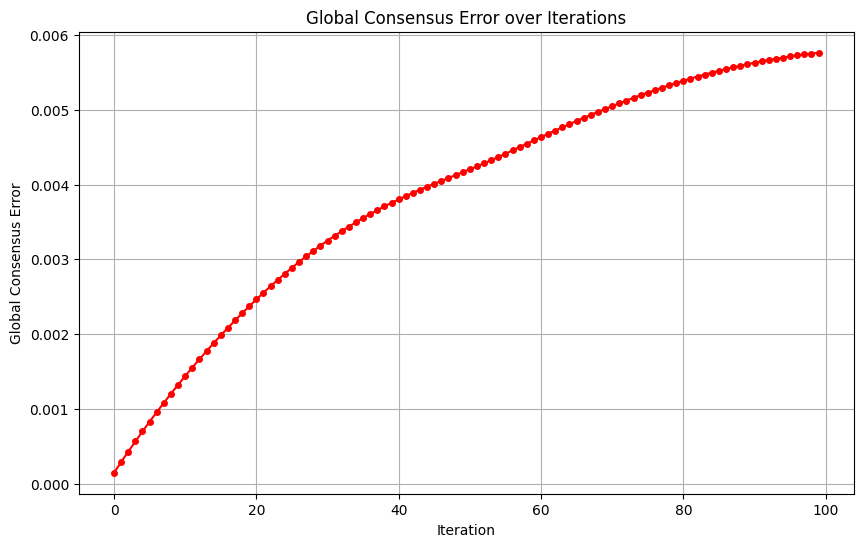

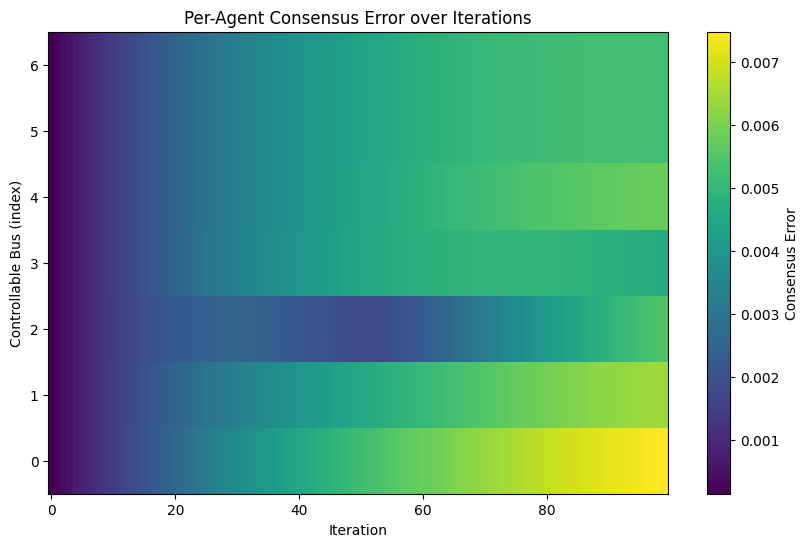

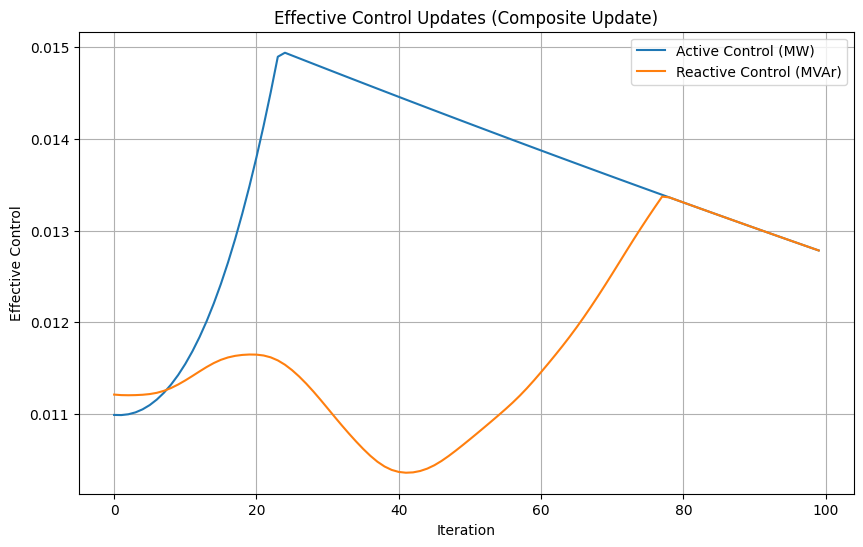

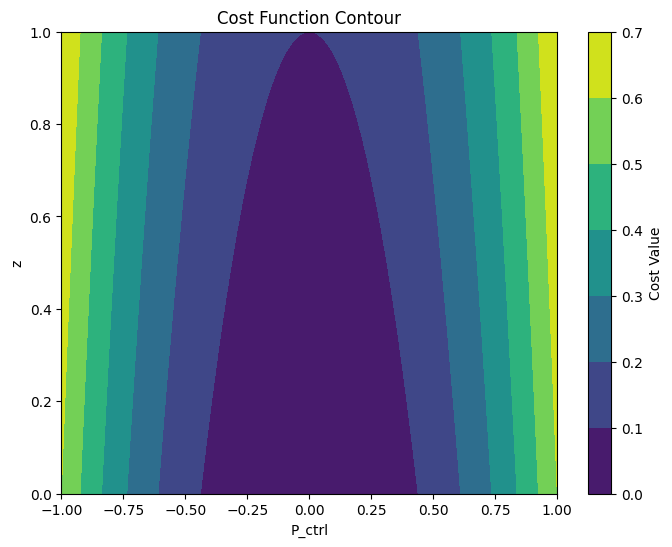

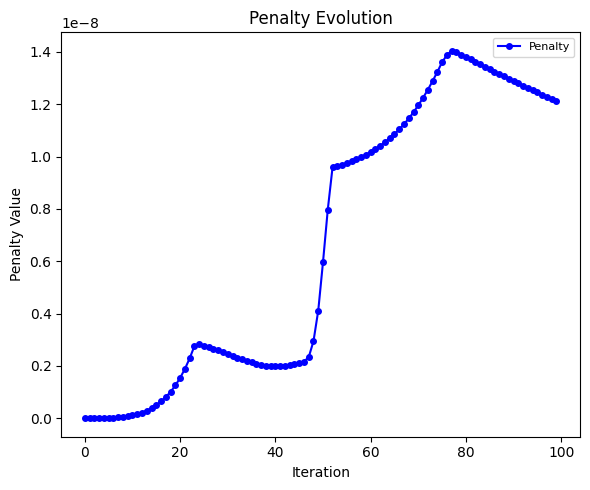

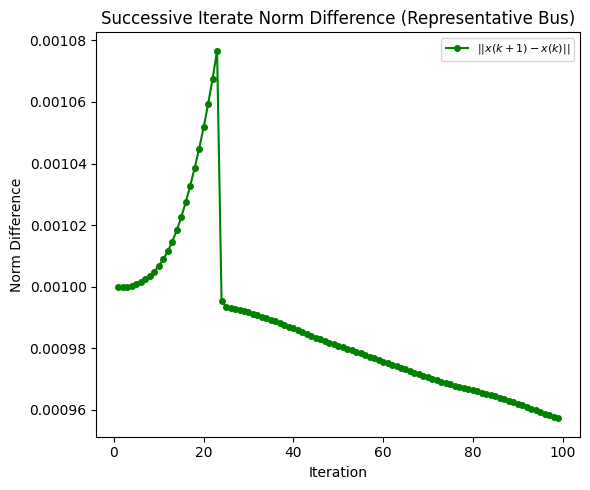

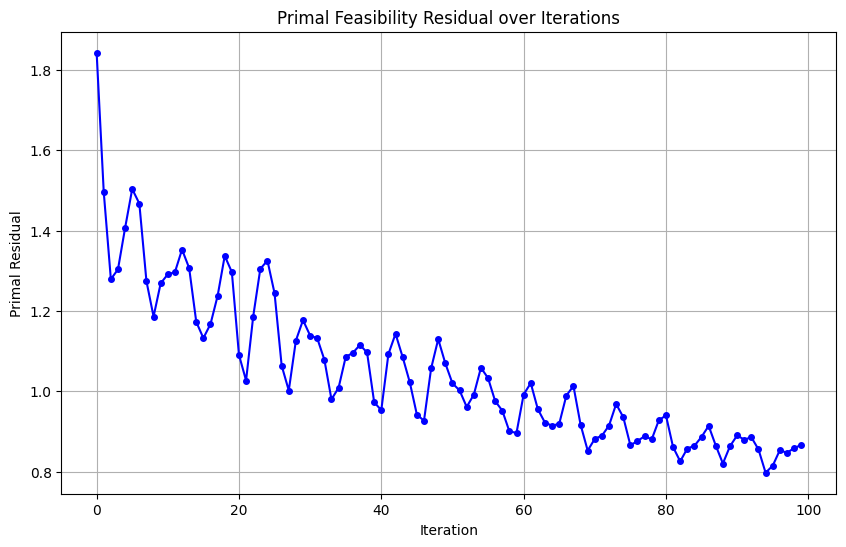

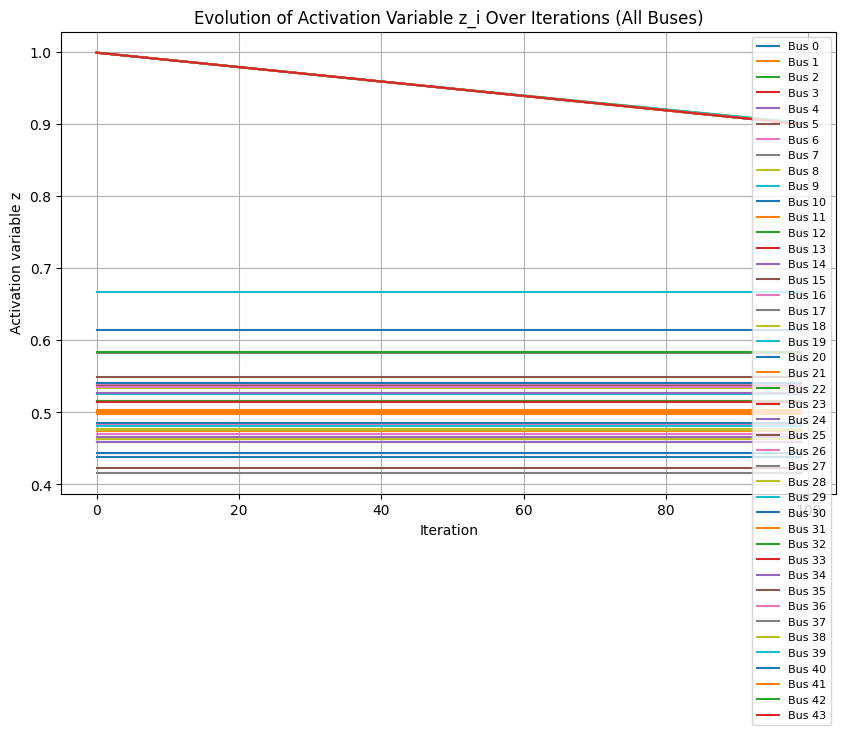

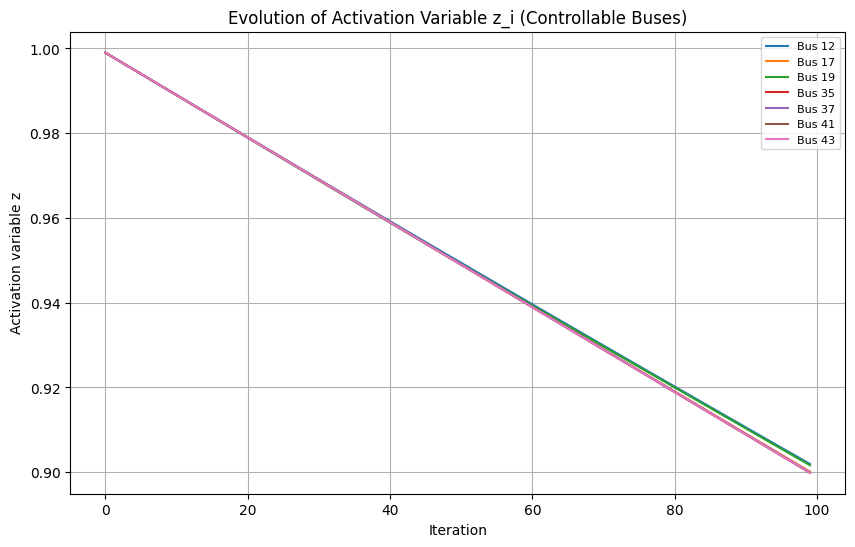

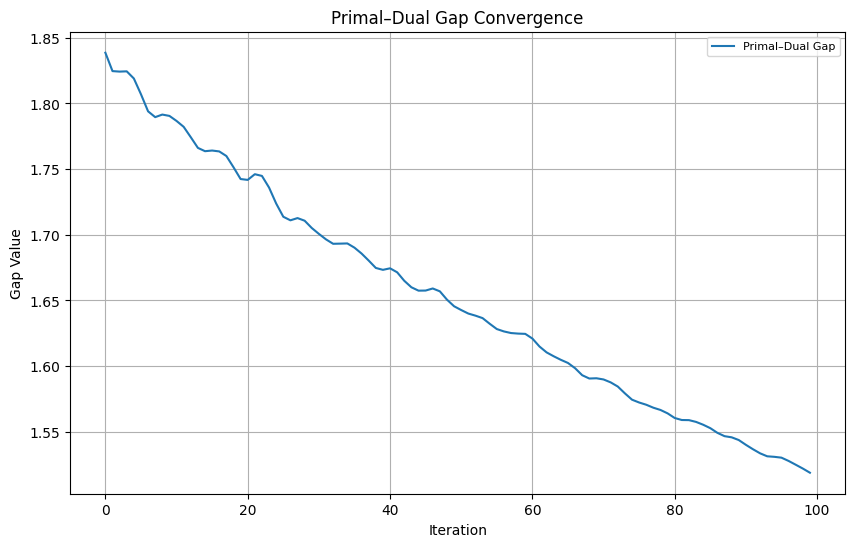

Final Controllable Values (Effective Control):
Bus 12: Effective Active = 0.0128 MW, Effective Reactive = 0.0128 MVAr
Bus 17: Effective Active = 0.0072 MW, Effective Reactive = 0.0127 MVAr
Bus 19: Effective Active = -0.0128 MW, Effective Reactive = -0.0128 MVAr
Bus 35: Effective Active = 0.0019 MW, Effective Reactive = 0.0036 MVAr
Bus 37: Effective Active = 0.0050 MW, Effective Reactive = 0.0115 MVAr
Bus 41: Effective Active = 0.0058 MW, Effective Reactive = 0.0059 MVAr
Bus 43: Effective Active = 0.0058 MW, Effective Reactive = 0.0059 MVAr
Final Voltage Deviations (Delta_V): [ 0.0087453  -0.00961626 -0.0203339  -0.02760101 -0.02877898 -0.03557273
 -0.04216266 -0.04472531 -0.04663107 -0.04828313 -0.05       -0.05
 -0.00142346 -0.02835002 -0.05       -0.05       -0.05       -0.0486035
 -0.05       -0.04803444 -0.00871667 -0.01084715 -0.02875397 -0.03232412
 -0.03066699 -0.04161142 -0.05       -0.05       -0.05       -0.05
 -0.05       -0.05       -0.05       -0.05       -0.05       -0.05

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandapower as pp

# PENALTY FUNCTION AND ITS DERIVATIVES (ReLU-like)

def phi(P_ctrl, Q_ctrl, z, S_max):
    val = P_ctrl**2 + Q_ctrl**2 - (S_max * z)**2
    return np.maximum(0, val)**2

def dphi_dP(P_ctrl, Q_ctrl, z, S_max):
    val = P_ctrl**2 + Q_ctrl**2 - (S_max * z)**2
    return 2 * np.maximum(val, 0) * (2 * P_ctrl)

def dphi_dQ(P_ctrl, Q_ctrl, z, S_max):
    val = P_ctrl**2 + Q_ctrl**2 - (S_max * z)**2
    return 2 * np.maximum(val, 0) * (2 * Q_ctrl)

def dphi_dz(P_ctrl, Q_ctrl, z, S_max):
    val = P_ctrl**2 + Q_ctrl**2 - (S_max * z)**2
    return 2 * np.maximum(val, 0) * (-2 * S_max**2 * z)

# Proximal Operator for φ:
def prox_phi(v, eta, rho, S_max, z):
    c = S_max * z
    norm_v = np.linalg.norm(v)
    if norm_v <= c:
        return v
    t = norm_v
    for _ in range(20):
        F = 4 * rho * t * (t**2 - c**2) + (1/eta) * (t - norm_v)
        F_prime = 12 * rho * t**2 - 4 * rho * c**2 + (1/eta)
        t_new = t - F / F_prime
        if abs(t_new - t) < 1e-6:
            t = t_new
            break
        t = t_new
    return t * (v / norm_v)

# ---------------------------
# Problem Setup and Variable Initialization
# ---------------------------
num_buses = len(net.bus.index)
ref_bus = 0

# Identify controllable buses from sgen data.
controllable_buses = list(net.sgen.bus.unique())
rep_bus = controllable_buses[0]

# Cost weights
alpha = np.ones(num_buses)   # Weight on (ΔV)²
beta = 0.1                   # Activation cost weight

# INITIALIZE PRIMAL & DUAL VARIABLES
lambda_P = np.zeros(num_buses)      # Dual variable for active power
lambda_Q = np.zeros(num_buses)      # Dual variable for reactive power
Delta_V = 0.01 * np.random.randn(num_buses)    # Voltage deviations (V)
Delta_theta = 0.01 * np.random.randn(num_buses)  # Angle deviations (rad)
z_init = 0.5 + 0.05 * np.random.randn(num_buses) # Activation variables

# INITIALIZE CONTROL VARIABLES FROM SGEN DATA
P_ctrl_init = np.zeros(num_buses)
Q_ctrl_init = np.zeros(num_buses)
S_max_arr = np.zeros(num_buses)
for bus in controllable_buses:
    sgen_entry = net.sgen[net.sgen.bus == bus].iloc[0]
    P_ctrl_init[bus] = sgen_entry.p_mw      # Active power (MW)
    Q_ctrl_init[bus] = sgen_entry.q_mvar      # Reactive power (MVAr)
    S_max_arr[bus]  = sgen_entry.sn_mva       # Maximum apparent power (MVA)
    z_init[bus] = 1.0                        # Set activation to 1

# SET BOX CONSTRAINTS FOR CONTROLLABLE DEVICES
P_ctrl_min = np.zeros(num_buses)
P_ctrl_max = np.zeros(num_buses)
Q_ctrl_min = np.zeros(num_buses)
Q_ctrl_max = np.zeros(num_buses)
for bus in controllable_buses:
    P_ctrl_min[bus] = -S_max_arr[bus]
    P_ctrl_max[bus] = S_max_arr[bus]
    Q_ctrl_min[bus] = -S_max_arr[bus]
    Q_ctrl_max[bus] = S_max_arr[bus]

# Voltage Limits
V0_kv = net.bus.vn_kv.values
V0 = V0_kv * 1e3  # in Volts
V_min = 0.95 * V0  # Minimum voltage for each bus
V_max = 1.05 * V0  # Maximum voltage for each bus

# CONSENSUS VARIABLES & VOLTAGE SENSITIVITY MAPPING
n_ctrl = len(controllable_buses)
s_init = np.zeros((num_buses, 2 * n_ctrl))
# Assume N and L are sensitivity matrices for ΔV with respect to controllable buses.
K_V = np.hstack((N[:, controllable_buses], L[:, controllable_buses]))  # Shape: (num_buses, 2*n_ctrl)
# Offset vector from measured per unit voltages (nominal 1.0 p.u.)
b_V = net.res_bus.vm_pu.values - 1.0
s = s_init.copy()

# OTHER PARAMETERS & COMMUNICATION SETUP
eta_state   = 0.01    # Step-size for state updates (ΔV, Δθ)
eta_control = 0.01    # Step-size for control updates
gamma_dual  = 0.01    # Dual update step-size
rho_penalty = 0.1     # Penalty weight for φ
iterations  = 100     # Number of iterations

# Create network graph via pandapower topology
nx_graph = pp.topology.create_nxgraph(net)
G = nx_graph

# HISTORY RECORDING

hist_eff_control      = []  # Records effective control [z*P_ctrl, z*Q_ctrl]
hist_iterates         = []  # Records iterate for representative bus: [P_ctrl, z]
hist_convergence      = []  # Norm difference between successive iterates
hist_Delta_V_all      = []  # History of voltage deviations
hist_Delta_theta_all  = []  # History of angle deviations
hist_z_all            = []  # History of activation variable z
hist_s_all            = []  # History of consensus variable s
hist_lambda_P         = []  # History of dual variable lambda_P
hist_lambda_Q         = []  # History of dual variable lambda_Q
hist_penalty          = []  # History of average penalty values
hist_primal_residual  = []  # Global power balance mismatch (primal residual)
hist_consensus_error  = []  # Average consensus error among controllable buses
hist_consensus_per_agent = []  # Per-agent consensus error over iterations
hist_global_consensus_error = []  # Global consensus error values
hist_primal_dual_gap  = []  # Primal–dual gap history

prev_iterate = None


# Lagrangian Value

def compute_lagrangian(Delta_V, Delta_theta, P_ctrl, Q_ctrl, z, lambda_P, lambda_Q):
    L_val = 0.0
    for i in range(num_buses):
        # Primal cost for bus i.
        cost = alpha[i] * (Delta_V[i]**2)
        if i in controllable_buses:
            cost += beta * z[i] + rho_penalty * phi(P_ctrl[i], Q_ctrl[i], z[i], S_max_arr[i])
        # Compute net injections.
        if i in controllable_buses:
            P_net = P_ctrl[i] * z[i] - P_load[i]
            Q_net = Q_ctrl[i] * z[i] - Q_load[i]
        else:
            P_net = -P_load[i]
            Q_net = -Q_load[i]
        Delta_P = P_net - P0[i]
        Delta_Q = Q_net - Q0[i]
        PF_approx = np.dot(H[i, :], Delta_theta) + np.dot(N[i, :], Delta_V)
        QF_approx = np.dot(K[i, :], Delta_theta) + np.dot(L[i, :], Delta_V)
        dual_term = lambda_P[i]*(Delta_P - PF_approx) + lambda_Q[i]*(Delta_Q - QF_approx)
        L_val += cost + dual_term
    return L_val

# MAIN LOOP: Distributed Dual + Consensus + Innovation Update

# Use local copies for updates.
Delta_V_local     = Delta_V.copy()
Delta_theta_local = Delta_theta.copy()
z_local           = z_init.copy()
lambda_P_local    = lambda_P.copy()
lambda_Q_local    = lambda_Q.copy()
P_ctrl_local      = P_ctrl_init.copy()
Q_ctrl_local      = Q_ctrl_init.copy()
s_local           = s_init.copy()

for k in range(iterations):
    # 1. Exchange Local Estimates (Consensus + Innovation)
    s_new = s_local.copy()
    for i in range(num_buses):
        neighbors = list(G.neighbors(i))
        if neighbors:
            consensus_term = eta_state * sum(s_local[j] - s_local[i] for j in neighbors)
        else:
            consensus_term = 0
        hat_u = np.zeros(2 * n_ctrl)
        if i in controllable_buses:
            pos = controllable_buses.index(i)
            hat_u[2*pos]   = P_ctrl_local[i] * z_local[i]
            hat_u[2*pos+1] = Q_ctrl_local[i] * z_local[i]
        s_new[i] = s_local[i] + consensus_term + eta_state * (hat_u - s_local[i])
    s_local = s_new.copy()

    # Global consensus estimates and error (for monitoring)
    s_global_avg = np.mean([s_local[i] for i in controllable_buses], axis=0)
    per_agent_error = [np.linalg.norm(s_local[i] - s_global_avg) for i in controllable_buses]
    hist_consensus_per_agent.append(per_agent_error)
    global_error = np.mean(per_agent_error)
    hist_global_consensus_error.append(global_error)

    # 2. Voltage Deviation Estimation: ΔV = K_V s + b_V
    for i in range(num_buses):
        Delta_V_local[i] = np.dot(K_V[i], s_local[i]).item() + b_V[i]

    # 3. Local State Updates
    for i in range(num_buses):
        grad_DV = 2 * alpha[i] * Delta_V_local[i]
        for j in range(num_buses):
            grad_DV -= N[j, i] * lambda_P_local[j] + L[j, i] * lambda_Q_local[j]
        Delta_V_local[i] = Delta_V_local[i] - eta_state * grad_DV
        #Delta_V_local[i] = np.clip(Delta_V_local[i], V_min[i] - V0[i], V_max[i] - V0[i])
        Delta_V_local[i] = np.clip(Delta_V_local[i], V_min[i] / V0[i] - 1, V_max[i] / V0[i] - 1)


        grad_Dtheta = 0.0
        for j in range(num_buses):
            grad_Dtheta -= H[j, i] * lambda_P_local[j] + K[j, i] * lambda_Q_local[j]
        Delta_theta_local[i] = Delta_theta_local[i] - eta_state * grad_Dtheta
    Delta_theta_local[ref_bus] = 0

    # 4. Local Control Updates (Composite Update)
    for i in controllable_buses:
        grad_P = rho_penalty * dphi_dP(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i]) \
                 + lambda_P_local[i] * z_local[i]
        grad_Q = rho_penalty * dphi_dQ(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i]) \
                 + lambda_Q_local[i] * z_local[i]
        grad_z = beta + rho_penalty * dphi_dz(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i]) \
                 + lambda_P_local[i] * P_ctrl_local[i] + lambda_Q_local[i] * Q_ctrl_local[i]
        z_local[i] = np.clip(z_local[i] - eta_control * grad_z, 0, 1)

        u_old = np.array([P_ctrl_local[i], Q_ctrl_local[i]])
        smooth_grad = np.array([lambda_P_local[i] * z_local[i], lambda_Q_local[i] * z_local[i]])
        v = u_old - eta_control * smooth_grad
        u_new = prox_phi(v, eta_control, rho_penalty, S_max_arr[i], z_local[i])
        P_ctrl_local[i], Q_ctrl_local[i] = u_new[0], u_new[1]

    # 5. Dual Updates via Gradient Ascent (using effective control)
    for i in range(num_buses):
        if i in controllable_buses:
            P_net = P_ctrl_local[i] * z_local[i] - P_load[i]
            Q_net = Q_ctrl_local[i] * z_local[i] - Q_load[i]
        else:
            P_net = -P_load[i]
            Q_net = -Q_load[i]
        Delta_P = P_net - P0[i]
        Delta_Q = Q_net - Q0[i]
        PF_approx = np.dot(H[i, :], Delta_theta_local) + np.dot(N[i, :], Delta_V_local)
        QF_approx = np.dot(K[i, :], Delta_theta_local) + np.dot(L[i, :], Delta_V_local)
        mismatch_P = (Delta_P - PF_approx).item()
        mismatch_Q = (Delta_Q - QF_approx).item()
        lambda_P_local[i] += gamma_dual * mismatch_P
        lambda_Q_local[i] += gamma_dual * mismatch_Q

    # 6. Projection onto Feasible Sets for Control Variables
    for i in controllable_buses:
        P_ctrl_local[i] = np.clip(P_ctrl_local[i], P_ctrl_min[i] * z_local[i], P_ctrl_max[i] * z_local[i])
        Q_ctrl_local[i] = np.clip(Q_ctrl_local[i], Q_ctrl_min[i] * z_local[i], Q_ctrl_max[i] * z_local[i])

    # 7. Record and Print Trajectory Every 10 Iterations
    current_eff = np.array([P_ctrl_local[rep_bus] * z_local[rep_bus], Q_ctrl_local[rep_bus] * z_local[rep_bus]])
    hist_eff_control.append(current_eff)
    if k % 10 == 0:
        print(f"Iteration {k}:")
        for bus in controllable_buses:
            eff_P_bus = P_ctrl_local[bus] * z_local[bus]
            eff_Q_bus = Q_ctrl_local[bus] * z_local[bus]
            print(f"  Bus {bus}: Effective Active = {eff_P_bus:.4f} MW, Effective Reactive = {eff_Q_bus:.4f} MVAr")
        obj = np.sum(alpha * (Delta_V_local**2)) + beta * np.sum(z_local) \
              + rho_penalty * np.sum([phi(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i])
                                       for i in controllable_buses])
        print(f"  Objective = {obj:.4f}")

    # ----- Primal–Dual Gap Computation & Additional History Recording -----
    # Primal objective (without dual contributions)
    primal_obj = np.sum(alpha * (Delta_V_local**2)) + beta * np.sum(z_local) + \
                 rho_penalty * np.sum([phi(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i])
                                      for i in controllable_buses])
    lagrangian_val = compute_lagrangian(Delta_V_local, Delta_theta_local, P_ctrl_local, Q_ctrl_local, z_local, lambda_P_local, lambda_Q_local)
    gap = np.abs(primal_obj - lagrangian_val).item()
    hist_primal_dual_gap.append(gap)

    current_iterate = np.array([P_ctrl_local[rep_bus], z_local[rep_bus]])
    hist_iterates.append(current_iterate)
    if prev_iterate is not None:
        hist_convergence.append(np.linalg.norm(current_iterate - prev_iterate))
    prev_iterate = current_iterate.copy()

    hist_Delta_V_all.append(Delta_V_local.copy())
    hist_Delta_theta_all.append(Delta_theta_local.copy())
    hist_z_all.append(z_local.copy())
    hist_s_all.append(s_local.copy())
    hist_lambda_P.append(lambda_P_local.copy())
    hist_lambda_Q.append(lambda_Q_local.copy())
    avg_pen = np.mean([phi(P_ctrl_local[i], Q_ctrl_local[i], z_local[i], S_max_arr[i])
                        for i in controllable_buses])
    hist_penalty.append(avg_pen)

    # --- Compute Primal Residual ---
    primal_res = 0.0
    for i in range(num_buses):
        if i in controllable_buses:
            P_net = P_ctrl_local[i] * z_local[i] - P_load[i]
            Q_net = Q_ctrl_local[i] * z_local[i] - Q_load[i]
        else:
            P_net = -P_load[i]
            Q_net = -Q_load[i]
        PF_approx = np.dot(H[i, :], Delta_theta_local) + np.dot(N[i, :], Delta_V_local)
        QF_approx = np.dot(K[i, :], Delta_theta_local) + np.dot(L[i, :], Delta_V_local)
        mismatch_P = P_net - PF_approx
        mismatch_Q = Q_net - QF_approx
        primal_res += mismatch_P**2 + mismatch_Q**2
    primal_res = np.sqrt(primal_res)
    hist_primal_residual.append(primal_res)

    # --- Compute Consensus Error for Controllable Buses ---
    cons_error = 0.0
    count = 0
    for i in controllable_buses:
        for j in list(G.neighbors(i)):
            if j in controllable_buses:
                cons_error += np.linalg.norm(s_local[i] - s_local[j])
                count += 1
    cons_error = cons_error / count if count > 0 else 0
    hist_consensus_error.append(cons_error)

# Compute final global consensus error
s_global_avg = np.mean([s_local[i] for i in controllable_buses], axis=0)
global_consensus_error = np.mean([np.linalg.norm(s_local[i] - s_global_avg) for i in controllable_buses])
hist_consensus_error.append(global_consensus_error)
print("Global Consensus Error:", global_consensus_error)

# Convert some histories to arrays for plotting
hist_global_consensus_error = np.array(hist_global_consensus_error)
hist_consensus_per_agent = np.array(hist_consensus_per_agent)
iterations_array = np.arange(len(hist_global_consensus_error))

# PLOTTING RESULTS

# Global consensus error over iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations_array, hist_global_consensus_error, 'r.-', markersize=8)
plt.xlabel('Iteration')
plt.ylabel('Global Consensus Error')
plt.title('Global Consensus Error over Iterations')
plt.grid(True)
plt.show()

# Per-agent consensus error heatmap
plt.figure(figsize=(10, 6))
plt.imshow(hist_consensus_per_agent.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Consensus Error')
plt.xlabel('Iteration')
plt.ylabel('Controllable Bus (index)')
plt.title('Per-Agent Consensus Error over Iterations')
plt.show()

# Effective control update plot (for representative bus)
hist_eff_control = np.array(hist_eff_control)
iterations_array_eff = np.arange(len(hist_eff_control))
plt.figure(figsize=(10, 6))
plt.plot(iterations_array_eff, hist_eff_control[:, 0], label='Active Control (MW)')
plt.plot(iterations_array_eff, hist_eff_control[:, 1], label='Reactive Control (MVAr)')
plt.xlabel('Iteration')
plt.ylabel('Effective Control')
plt.title('Effective Control Updates (Composite Update)')
plt.legend()
plt.grid(True)
plt.show()

# Contour plot for cost function over P_ctrl and z (using average S_max)
S_max_avg = np.mean(S_max_arr)
P_grid, z_grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(0, 1, 100))
J_grid = 0.5 * P_grid**2 + beta * z_grid + rho_penalty * np.maximum(0, P_grid**2 - (S_max_avg*z_grid)**2)**2

plt.figure(figsize=(8,6))
plt.contourf(P_grid, z_grid, J_grid, cmap='viridis')
plt.xlabel('P_ctrl')
plt.ylabel('z')
plt.title('Cost Function Contour')
plt.colorbar(label='Cost Value')
plt.show()

# Penalty evolution plot
plt.figure(figsize=(6,5))
plt.plot(np.arange(len(hist_penalty)), hist_penalty, 'b.-', markersize=8, label="Penalty")
plt.xlabel("Iteration")
plt.ylabel("Penalty Value")
plt.title("Penalty Evolution")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Convergence measure plot (successive iterate norm difference)
plt.figure(figsize=(6,5))
plt.plot(np.arange(1, len(hist_convergence)+1), hist_convergence, 'g.-', markersize=8, label=r"$||x(k+1)-x(k)||$")
plt.xlabel("Iteration")
plt.ylabel("Norm Difference")
plt.title("Successive Iterate Norm Difference (Representative Bus)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot Primal Residual over Iterations
plt.figure(figsize=(10, 6))
plt.plot(np.arange(iterations), np.squeeze(hist_primal_residual), 'b.-', markersize=8)
plt.xlabel('Iteration')
plt.ylabel('Primal Residual')
plt.title('Primal Feasibility Residual over Iterations')
plt.grid(True)
plt.show()

# Plot Evolution of Activation Variable z (all buses)
hist_z_all = np.array(hist_z_all)
plt.figure(figsize=(10, 6))
for bus in range(num_buses):
    plt.plot(np.arange(iterations), hist_z_all[:, bus], label=f'Bus {bus}')
plt.xlabel('Iteration')
plt.ylabel('Activation variable z')
plt.title('Evolution of Activation Variable z_i Over Iterations (All Buses)')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

# Plot Evolution of Activation Variable z (controllable buses)
plt.figure(figsize=(10, 6))
for bus in controllable_buses:
    plt.plot(np.arange(iterations), hist_z_all[:, bus], label=f'Bus {bus}')
plt.xlabel('Iteration')
plt.ylabel('Activation variable z')
plt.title('Evolution of Activation Variable z_i (Controllable Buses)')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

# Plot Primal–Dual Gap Convergence
hist_primal_dual_gap_array = np.array(hist_primal_dual_gap)
plt.figure(figsize=(10,6))
plt.plot(hist_primal_dual_gap_array, label='Primal–Dual Gap')
plt.xlabel('Iteration')
plt.ylabel('Gap Value')
plt.title('Primal–Dual Gap Convergence')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

# PRINT FINAL RESULTS

print("Final Controllable Values (Effective Control):")
for i in controllable_buses:
    eff_P = P_ctrl_local[i] * z_local[i]
    eff_Q = Q_ctrl_local[i] * z_local[i]
    print(f"Bus {i}: Effective Active = {float(eff_P):.4f} MW, Effective Reactive = {float(eff_Q):.4f} MVAr")

print("Final Voltage Deviations (Delta_V):", Delta_V_local)
print("Final Angle Deviations (Delta_theta):", Delta_theta_local)
print("Final Dual Variables:")
print("lambda_P:", lambda_P_local)
print("lambda_Q:", lambda_Q_local)

if len(hist_iterates) > 1:
    duality_gap = np.linalg.norm(hist_iterates[-1] - hist_iterates[-2])
else:
    duality_gap = 0
print("\nApproximate Duality Gap (residual norm):", duality_gap)

for i in controllable_buses:
    print(f"Bus {i}: P_ctrl = {float(P_ctrl_local[i]):.4f} MW, Q_ctrl = {float(Q_ctrl_local[i]):.4f} MVAr, Activation z = {float(z_local[i]):.4f}")


# Update

In [56]:
# ---------------------------
# Update Pandapower Network with Activation (z) Results
# ---------------------------
print("\n--- Before Update ---")
print("Controllable Buses:", controllable_buses)
print("P_ctrl:", P_ctrl)
print("Q_ctrl:", Q_ctrl)
print("z:", z)
print("Delta_V:", Delta_V)
print("Delta_theta:", Delta_theta)
print("\nInitial net.sgen before update:\n", net.sgen[['bus', 'p_mw', 'q_mvar', 'controllable', 'in_service']])
print("\nInitial net.bus before update (vm_pu, va_degree):\n", net.res_bus[['vm_pu', 'va_degree']])

for bus in controllable_buses:
    print(f"\nProcessing bus: {bus}")
    # Locate the controllable sgen on this bus (assumes one per bus)
    sgen_idx = net.sgen[(net.sgen.bus == bus) & (net.sgen.controllable)].index
    print(f"  sgen_idx for bus {bus}: {sgen_idx}")
    if not sgen_idx.empty:
        idx = sgen_idx[0]
        print(f"  Updating sgen index: {idx}")
        print(f"  P_ctrl[{bus}] * z[{bus}] = {P_ctrl[bus] * z[bus]}")
        print(f"  Q_ctrl[{bus}] * z[{bus}] = {Q_ctrl[bus] * z[bus]}")
        # Update sgen injections based on the computed control values scaled by activation z
        net.sgen.at[idx, 'p_mw'] = P_ctrl[bus] * z[bus]
        net.sgen.at[idx, 'q_mvar'] = Q_ctrl[bus] * z[bus]
        net.sgen.at[idx, 'in_service'] = True
        print(f"  Updated net.sgen for index {idx}: p_mw={net.sgen.at[idx, 'p_mw']}, q_mvar={net.sgen.at[idx, 'q_mvar']}, in_service={net.sgen.at[idx, 'in_service']}")
    else:
        print(f"  No controllable sgen found on bus {bus}")

# Update bus voltage conditions based on the algorithm results.
print("\n--- Updating Bus Voltages ---")
print("Initial net.bus before voltage update (vm_pu, va_degree):\n", net.res_bus[['vm_pu', 'va_degree']])
for i in range(num_buses):
    new_vm_pu = 1 + Delta_V[i]
    new_va_degree = Delta_theta[i] * 180 / np.pi
    print(f"  Bus {i}: Delta_V[{i}]={Delta_V[i]}, Delta_theta[{i}]={Delta_theta[i]}")
    print(f"  Updating bus {i}: vm_pu to {new_vm_pu}, va_degree to {new_va_degree}")
    net.bus.at[i, 'vm_pu'] = new_vm_pu
    net.bus.at[i, 'va_degree'] = new_va_degree

print("\nFinal net.bus after update (vm_pu, va_degree):\n", net.bus[['vm_pu', 'va_degree']])

# Run power flow with the updated network.
print("\n--- Running Power Flow ---")
#pp.runpp(net)
#pp.runpp(net, algorithm="nr")  # Newton-Raphson (default)
#pp.runpp(net, algorithm="gs")  # Gauss-Seidel
pp.runpp(net, algorithm="bfsw") #Backward/Forward Sweep

#https://pandapower.readthedocs.io/en/v2.0.1/powerflow/ac.html

print("\nUpdated Power Flow Results (Bus Voltages and Angles):")
print(net.res_bus[['vm_pu', 'va_degree']])
if not net.gen.empty:
    print("\nGeneration Results (net.gen):")
    print(net.res_gen[['p_mw', 'q_mvar']])
if not net.ext_grid.empty:
    print("\nExternal Grid Results (net.ext_grid):")
    print(net.res_ext_grid[['p_mw', 'q_mvar']])
if not net.sgen.empty:
    print("\nControllable Sgen Results (net.sgen):")
    print(net.res_sgen[['p_mw', 'q_mvar']])


--- Before Update ---
Controllable Buses: [np.int64(12), np.int64(17), np.int64(19), np.int64(35), np.int64(37), np.int64(41), np.int64(43)]
P_ctrl: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.011 0.    0.    0.    0.    0.011 0.    0.011 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.011
 0.    0.011 0.    0.    0.    0.011 0.    0.011]
Q_ctrl: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01122224 0.         0.         0.         0.         0.01122224
 0.         0.01122224 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01122224
 0.         0.01122224 0.         0.         0.         0.01122224
 0.         0.01122224]
z: [0.56457732 0.41438998 0.47799449 0.54918624 0.58095976 0.51230678
 0.47223807 0.48314633 0.49124355 0.52682257 0.4

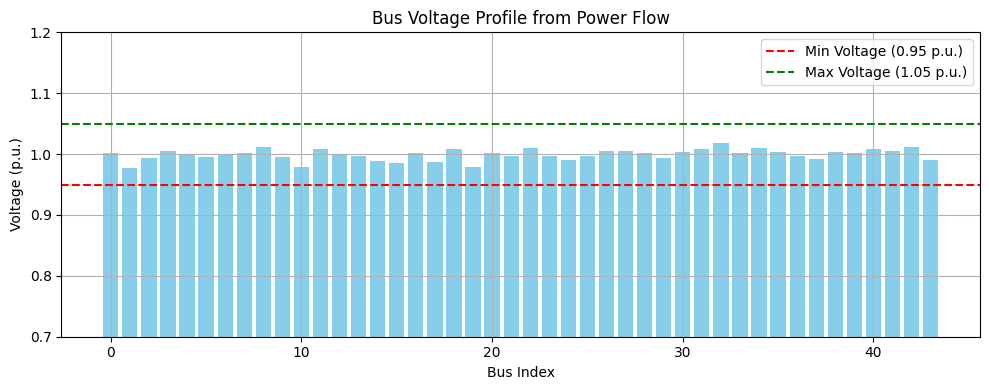

In [57]:
# Extract data from net.res_bus for plotting
bus_indices = np.arange(len(net.res_bus))
voltages = net.bus['vm_pu'].values  # per unit voltages
angles = net.bus['va_degree'].values  # angles in degrees

# Plot Bus Voltages (in p.u.)
plt.figure(figsize=(10, 4))
plt.bar(bus_indices, voltages, color='skyblue')
plt.axhline(0.95, color='red', linestyle='--', label='Min Voltage (0.95 p.u.)')
plt.axhline(1.05, color='green', linestyle='--', label='Max Voltage (1.05 p.u.)')
plt.xlabel("Bus Index")
plt.ylabel("Voltage (p.u.)")
plt.title("Bus Voltage Profile from Power Flow")
plt.ylim(0.7, 1.2)  # Set y-axis limits between 0.7 and 1.2
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

# Save the initial bus results for later comparison
after_df = net.res_bus[['vm_pu', 'va_degree']].copy()

# Create the Plotly figure
fig = go.Figure()

# Add bar chart for bus voltages
fig.add_trace(go.Bar(
    x=bus_indices,
    y=voltages,
    marker_color='skyblue',
    name='Voltage (p.u.)'
))

# Add horizontal lines for the voltage limits
fig.add_hline(y=0.95,
              line=dict(color='red', dash='dash'),
              annotation_text='Min Voltage (0.95 p.u.)',
              annotation_position="bottom right")
fig.add_hline(y=1.05,
              line=dict(color='green', dash='dash'),
              annotation_text='Max Voltage (1.05 p.u.)',
              annotation_position="top right")

# Configure layout settings with Times New Roman font
fig.update_layout(
    title={
        "text": "Voltage drop - Intervention",
        "font": {"family": "Times New Roman", "size": 20}
    },
    xaxis_title={
        "text": "Bus Index",
        "font": {"family": "Times New Roman", "size": 14}
    },
    yaxis_title={
        "text": "Voltage (p.u.)",
        "font": {"family": "Times New Roman", "size": 14}
    },
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    ),
    yaxis=dict(range=[0.7, 1.2]),
    template="plotly_white",
    legend=dict(
        font=dict(family="Times New Roman", size=12, color="black"),
        x=0.01, y=0.99
    )
)

# Display the plot (optional)
fig.show()

# Save the figure as a PDF file using kaleido.
pio.write_image(fig, "bus_voltage_profile_after.pdf", format="pdf")